# Walking Distances

Based on: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb

How far can you travel on foot in 5-10-15-20-25 minutes?

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline

In [2]:
# configure the place, network type, trip times, and travel speed
place = '13th district, Budapest, Hungary'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] # in minutes
travel_speed = 4.5 # walking speed in km/hour

## Download and Prep the Street Network

In [3]:
# download the street network
G = ox.graph_from_place(place, network_type = network_type)

In [4]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges = False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

In [5]:
# add an edge attribute from time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000/60 # km per hour to meter mer minute
for _, _, _, data in G.edges(data = True, keys = True):
    data['time'] = data['length'] / meters_per_minute

## Plot Nodes You Can Reach on Foot Within Each Time

How far can you walk in 5, 10, 15, 20, 25 minutes from the origin node? We'll use NetworkX to induce a subgraph of G within each distance, based on trip time and travel speed.

In [6]:
# get one color fro each isochrone
iso_colors = ox.plot.get_colors(n = len(trip_times), cmap = 'plasma', start = 0, return_hex = True)

How far can you walk in 5, 10, 15, 20, 25 minutes from the origin node? We'll use a convex hull, which isn't perfectly accurate. A concave hull would be better, but shapely doesn't offer that.

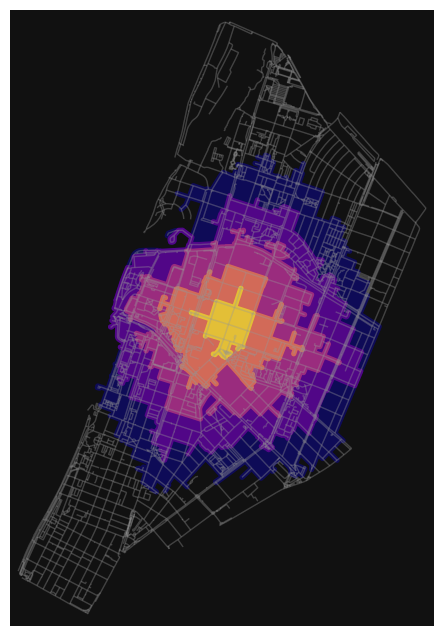

In [10]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

# make the isochore polys
isochrone_polys = make_iso_polys(G, edge_buff = 25, node_buff = 0, infill = True)
gdf = gpd.GeoDataFrame(geometry = isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(G,
                        show = False,
                        close = False,
                        edge_color = '#999999',
                        edge_alpha = 0.2,
                        node_size = 0)

gdf.plot(ax = ax, color = iso_colors, ec = 'none', alpha = 0.6, zorder = -1)
fig.savefig('images/walking_distance.png', dpi = 100)
plt.show()